# Heavylight + Heavytables Examples: Vectorised

In [1]:
import heavylight
import heavytables
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
mort = heavytables.Table.read_csv('csv_tables/fake_tmnl16_bound.csv')
mort.df

,age|int,dur|int_bound,q_x|float
0,18,0,0.000005
6,19,0,0.000006
12,20,0,0.000006
18,21,0,0.000007
24,22,0,0.000008
...,...,...,...
581,114,5,0.201897
587,115,5,0.223130
593,116,5,0.246597
599,117,5,0.272532


In [95]:
class ExampleModel(heavylight.Model):
    def t(self, t):
        return t
    
    def num_active(self, t):
        if t == 0:
            return self.data['initial_pols_if']
        else:
            return self.num_active(t - 1) - self.num_deaths(t - 1) # - self.num_lapses(t - 1)

    def num_deaths(self, t):
        return self.num_active(t) * self.q_x_m(t)
    
    def q_x_m(self, t):
        """Monthly mortality rate"""
        return 1 - (1 - self.q_x(t))**(1/12)
    
    def q_x(self, t):
        """annual mortality rate"""
        return mort[self.age(t), self.dur(t)] #TODO: pass this in as the basis rather than using global.
    
    def age(self, t):
        if t == 0:
            return self.data['init_age']
        elif t % 12 == 0:
            return self.age(t - 1) + 1
        else:
            return self.age(t - 1)
        
    def dur(self, t):
        """duration in force at time t"""
        return t  # assume all policies start at t=0, i.e. new business rather than existing business.
    
    def forward_rate(self):
        """monthly forward rate, for laziness flat but should use a curve"""
        return (1 + 0.04)**(1/12) - 1
    
    def disc_factor(self, t):
        if t == 0:
            return 1.0
        else:
            return self.disc_factor(t - 1) / (1 + self.forward_rate())
        
    def expected_claims(self, t):
        return self.data['sum_assured'] * self.num_deaths(t)
    
    def pv_claim(self, t):
        """present value of the claim occuring at time t"""
        return self.expected_claims(t) * self.disc_factor(t)
        


In [123]:
# define our data
rng = np.random.default_rng(seed=42)
policies = 100_000
data = dict(
    init_age = rng.integers(low=20, high=75, size=policies),
    initial_pols_if = np.ones(policies),
    sum_assured = 100_000.0 * np.ones(policies),
)
pd.DataFrame(data)

,init_age,initial_pols_if,sum_assured
0,24,1.0,100000.0
1,62,1.0,100000.0
2,56,1.0,100000.0
3,44,1.0,100000.0
4,43,1.0,100000.0
...,...,...,...
99995,74,1.0,100000.0
99996,20,1.0,100000.0
99997,51,1.0,100000.0
99998,20,1.0,100000.0


In [127]:
def read_data(csv_path):
    df = pd.read_csv(csv_path)
    data = {}
    for col in df:
        data[col] = df[col].values
    return data

data = read_data(r'data/data_10000.csv')


In [128]:
proj = ExampleModel(do_run=True, proj_len=241, data=data)
proj.ToDataFrame()

,t,age,disc_factor,dur,expected_claims,num_active,num_deaths,pv_claim,q_x,q_x_m
0,0,"[20, 49, 27, 36, 50, 37, 25, 56, 56, 26, 35, 3...",1.000000,0,"[0.06335710641399928, 0.5784594862973336, 0.02...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[5.120014417991925e-07, 9.305976291784646e-06,...","[0.06335710641399928, 0.5784594862973336, 0.02...","[6.144e-06, 0.000111666, 1.2373e-05, 3.0432e-0...","[5.120014417991925e-07, 9.305976291784646e-06,..."
1,1,"[20, 49, 27, 36, 50, 37, 25, 56, 56, 26, 35, 3...",0.996737,1,"[0.07739178658449931, 0.7065326129649828, 0.03...","[0.9999994879985582, 0.9999906940237082, 0.999...","[6.25418497741299e-07, 1.1366354777428939e-05,...","[0.07713925274402211, 0.704227156507021, 0.031...","[7.505e-06, 0.000136389, 1.5112e-05, 3.717e-05...","[6.254188179566356e-07, 1.1366460553441371e-05..."
2,2,"[20, 49, 27, 36, 50, 37, 25, 56, 56, 26, 35, 3...",0.993485,2,"[0.09452008157368802, 0.8629635324244462, 0.03...","[0.9999988625800604, 0.9999793276689308, 0.999...","[7.63835673436191e-07, 1.388293971081799e-05, ...","[0.09390423908061955, 0.8573409218173964, 0.03...","[9.166e-06, 0.000166586, 1.8458e-05, 4.54e-05,...","[7.638365422391047e-07, 1.3883226709476837e-05..."
3,3,"[20, 49, 27, 36, 50, 37, 25, 56, 56, 26, 35, 3...",0.990243,3,"[0.11544321285859184, 1.0540261180255173, 0.04...","[0.9999980987443869, 0.99996544472922, 0.99999...","[9.329196798114805e-07, 1.6956662130397638e-05...","[0.11431680292400326, 1.0437417066577042, 0.04...","[1.1195e-05, 0.000203468, 2.2545e-05, 5.5452e-...","[9.329214535336305e-07, 1.6957248092697164e-05..."
4,4,"[20, 49, 27, 36, 50, 37, 25, 56, 56, 26, 35, 3...",0.987012,4,"[0.14100677209671947, 1.2873983936842435, 0.05...","[0.9999971658247071, 0.9999484880670896, 0.999...","[1.1395039120823592e-06, 2.0711042369437635e-0...","[0.13917530801672973, 1.2706770413718036, 0.05...","[1.3674e-05, 0.000248517, 2.7536e-05, 6.7729e-...","[1.1395071416453462e-06, 2.0712109290221825e-0..."
...,...,...,...,...,...,...,...,...,...,...
236,236,"[39, 68, 46, 55, 69, 56, 44, 75, 75, 45, 54, 5...",0.462393,236,"[1.1504371517330247, 10.337436670949963, 0.468...","[0.9990260344625841, 0.9824365568346715, 0.998...","[9.296912591584438e-06, 0.00016630367874758626...","[0.5319537710549488, 4.779955525488521, 0.2167...","[0.000111666, 0.002029431, 0.000224867, 0.0005...","[9.305976291784646e-06, 0.00016927676152789228..."
237,237,"[39, 68, 46, 55, 69, 56, 44, 75, 75, 45, 54, 5...",0.460884,237,"[1.1504264457921654, 10.335686783147805, 0.468...","[0.9990167375499925, 0.9822702531559239, 0.998...","[9.296826074736273e-06, 0.00016627552739941772...","[0.5302130411798159, 4.763551761191743, 0.2160...","[0.000111666, 0.002029431, 0.000224867, 0.0005...","[9.305976291784646e-06, 0.00016927676152789228..."
238,238,"[39, 68, 46, 55, 69, 56, 44, 75, 75, 45, 54, 5...",0.459380,238,"[1.1504157399509356, 10.333937191560986, 0.468...","[0.9990074407239178, 0.9821039776285244, 0.998...","[9.296739558693234e-06, 0.00016624738081661818...","[0.5284780075524834, 4.7472042910344525, 0.215...","[0.000111666, 0.002029431, 0.000224867, 0.0005...","[9.305976291784646e-06, 0.00016927676152789228..."
239,239,"[39, 68, 46, 55, 69, 56, 44, 75, 75, 45, 54, 5...",0.457881,239,"[1.1504050342093337, 10.332187896139367, 0.468...","[0.998998143984359, 0.9819377302477078, 0.9979...","[9.29665304345531e-06, 0.00016621923899838107,...","[0.5267486515329313, 4.730912921827449, 0.2146...","[0.000111666, 0.002029431, 0.000224867, 0.0005...","[9.305976291784646e-06, 0.00016927676152789228..."


<Axes: >

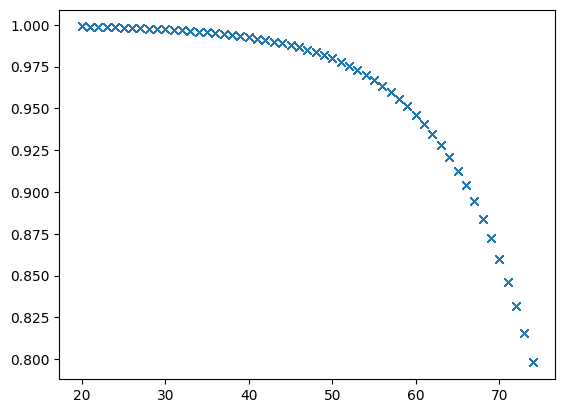

In [129]:
sns.scatterplot(x=proj.age(0), y=proj.num_active(240), marker='x')

<Axes: ylabel='Density'>

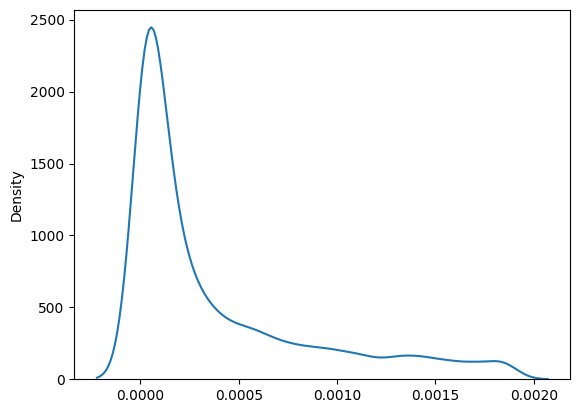

In [130]:
sns.kdeplot(x=proj.num_deaths(240))

In [131]:
df = proj.ToDataFrame()
df.head(3)

,t,age,disc_factor,dur,expected_claims,num_active,num_deaths,pv_claim,q_x,q_x_m
0,0,"[20, 49, 27, 36, 50, 37, 25, 56, 56, 26, 35, 3...",1.000000,0,"[0.06335710641399928, 0.5784594862973336, 0.02...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[5.120014417991925e-07, 9.305976291784646e-06,...","[0.06335710641399928, 0.5784594862973336, 0.02...","[6.144e-06, 0.000111666, 1.2373e-05, 3.0432e-0...","[5.120014417991925e-07, 9.305976291784646e-06,..."
1,1,"[20, 49, 27, 36, 50, 37, 25, 56, 56, 26, 35, 3...",0.996737,1,"[0.07739178658449931, 0.7065326129649828, 0.03...","[0.9999994879985582, 0.9999906940237082, 0.999...","[6.25418497741299e-07, 1.1366354777428939e-05,...","[0.07713925274402211, 0.704227156507021, 0.031...","[7.505e-06, 0.000136389, 1.5112e-05, 3.717e-05...","[6.254188179566356e-07, 1.1366460553441371e-05..."
2,2,"[20, 49, 27, 36, 50, 37, 25, 56, 56, 26, 35, 3...",0.993485,2,"[0.09452008157368802, 0.8629635324244462, 0.03...","[0.9999988625800604, 0.9999793276689308, 0.999...","[7.63835673436191e-07, 1.388293971081799e-05, ...","[0.09390423908061955, 0.8573409218173964, 0.03...","[9.166e-06, 0.000166586, 1.8458e-05, 4.54e-05,...","[7.638365422391047e-07, 1.3883226709476837e-05..."


In [132]:
df['num_active'].map(lambda x: x[9999])

0      1.000000
1      0.999999
2      0.999997
3      0.999996
4      0.999994
         ...   
236    0.997834
237    0.997813
238    0.997792
239    0.997772
240    0.997751
Name: num_active, Length: 241, dtype: float64

In [133]:
def get_policy_df(model_inst, index):
    """Pull out results for one policy"""
    full_df = model_inst.ToDataFrame()
    for col in full_df:
        if isinstance(full_df[col].iloc[0],np.ndarray):
            full_df[col] = full_df[col].map(lambda x: x[index])
    return full_df

In [134]:
# grab the index for the oldest policy
data['init_age'].argmax()

43

In [135]:
# view the policy data for this
get_policy_df(proj, 140)

,t,age,disc_factor,dur,expected_claims,num_active,num_deaths,pv_claim,q_x,q_x_m
0,0,46,1.000000,0,1.496251,1.000000,0.000007,1.496251,0.000083,0.000007
1,1,46,0.996737,1,1.827522,0.999993,0.000008,1.821559,0.000101,0.000008
2,2,46,0.993485,2,2.232157,0.999985,0.000010,2.217614,0.000123,0.000010
3,3,46,0.990243,3,2.726364,0.999974,0.000013,2.699762,0.000151,0.000013
4,4,46,0.987012,4,3.330002,0.999962,0.000015,3.286751,0.000184,0.000015
...,...,...,...,...,...,...,...,...,...,...
236,236,65,0.462393,236,26.856024,0.986961,0.000124,12.418030,0.001503,0.000125
237,237,65,0.460884,237,26.852657,0.986837,0.000124,12.375957,0.001503,0.000125
238,238,65,0.459380,238,26.849290,0.986713,0.000124,12.334027,0.001503,0.000125
239,239,65,0.457881,239,26.845924,0.986590,0.000124,12.292239,0.001503,0.000125


In [136]:
def sum_proj(proj):
    """Sum up results across the dataframe, note that some variables will not be sensible"""
    full_df = proj.ToDataFrame()
    for col in full_df:
        if isinstance(full_df[col].iloc[0],np.ndarray):
            full_df[col] = full_df[col].apply(np.sum)
    return full_df

sum_proj(proj)

,t,age,disc_factor,dur,expected_claims,num_active,num_deaths,pv_claim,q_x,q_x_m
0,0,468125,1.000000,0,27608.085645,10000.000000,0.212546,27608.085645,2.549717,0.212546
1,1,468125,0.996737,1,33721.033250,9999.787454,0.259608,33610.999584,3.114232,0.259624
2,2,468125,0.993485,2,41187.620994,9999.527846,0.317091,40919.264399,3.803731,0.317133
3,3,468125,0.990243,3,50307.655496,9999.210755,0.387303,49816.790407,4.645888,0.387389
4,4,468125,0.987012,4,61447.375922,9998.823451,0.473065,60649.267716,5.674500,0.473221
...,...,...,...,...,...,...,...,...,...,...
236,236,658125,0.462393,236,450952.826114,9616.189848,3.472075,208517.306711,46.338933,3.884902
237,237,658125,0.460884,237,450476.622140,9612.717773,3.468412,207617.428023,46.338933,3.884902
238,238,658125,0.459380,238,450001.102268,9609.249361,3.464753,206721.516113,46.338933,3.884902
239,239,658125,0.457881,239,449526.265383,9605.784608,3.461100,205829.553138,46.338933,3.884902


In [137]:
# using sum will sum each policy separately (over all t) - most useful for calculating present values
proj.pv_claim.sum()

array([77.031728, 698.211629, 31.405106, ..., 180.343605, 413.950059,
       339.828118])

In [138]:
proj.disc_factor(12) * 1.04 # check discount factor works, i.e. 12 months compound is 1/1.04

0.9999999999999993

In [143]:
def variable_to_df(proj, variable_name):
    """expand a column out to a dataframe"""
    return pd.DataFrame(getattr(proj, variable_name).values)

In [144]:
variable_to_df(proj, 'pv_claim')

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.063357,0.578459,0.025842,0.027628,0.904451,0.424587,0.100672,1.544714,4.645631,0.219690,...,1.451702,4.027188,0.666684,0.446552,16.383912,8.221853,0.194492,0.148357,0.345619,0.279652
1,0.077139,0.704227,0.031460,0.033635,1.101094,0.516907,0.122561,1.880575,5.655712,0.267462,...,1.767353,4.902800,0.811631,0.543643,19.946346,10.009490,0.236781,0.180600,0.420765,0.340464
2,0.093904,0.857341,0.038300,0.040948,1.340497,0.629289,0.149204,2.289455,6.885392,0.325624,...,2.151647,5.968815,0.988101,0.661841,24.283484,12.185852,0.288265,0.219858,0.512249,0.414490
3,0.114317,1.043742,0.046628,0.049851,1.631946,0.766097,0.181645,2.787236,8.382438,0.396422,...,2.619510,7.266618,1.202932,0.805742,29.563788,14.835430,0.350937,0.267667,0.623624,0.504595
4,0.139175,1.270677,0.056765,0.060689,1.986773,0.932670,0.221142,3.393252,10.204991,0.482600,...,3.189125,8.846625,1.464477,0.980929,35.992461,18.061149,0.427231,0.325873,0.759216,0.614293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,0.531954,4.779956,0.216761,0.231112,7.460473,3.550021,0.844721,12.548094,37.737602,1.843149,...,10.767213,31.811959,5.533098,3.668288,121.518745,64.946865,1.627682,1.245248,2.807546,2.345279
237,0.530213,4.763552,0.216050,0.230347,7.434738,3.538257,0.841952,12.502881,37.601628,1.837103,...,10.718574,31.688411,5.514352,3.655483,120.969814,64.694631,1.622304,1.241171,2.797430,2.337578
238,0.528478,4.747204,0.215341,0.229585,7.409091,3.526532,0.839191,12.457831,37.466144,1.831077,...,10.670156,31.565343,5.495669,3.642722,120.423363,64.443376,1.616942,1.237107,2.787350,2.329902
239,0.526749,4.730913,0.214634,0.228825,7.383533,3.514845,0.836440,12.412944,37.331147,1.825072,...,10.621956,31.442752,5.477049,3.630005,119.879380,64.193097,1.611599,1.233056,2.777307,2.322251
